# PART A: CONVOLUTIONAL NEURAL NETWORK
---

## Preparing the required libraries

In [1]:
# Helper libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For model
from tensorflow.keras import models, callbacks, layers as tf_layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from collections import Counter

# For hyperparemeter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

## Background research
***
The primary goal in DELE CA1 Part A is to develop a image classifier using a deep learning network capable of accurately categorizing vegetables into its distinct classes.

The challenge lies in creating a comprehensive model that can differentiate between various types of vegetables, each with its unique visual characteristics. Achieving accurate classification involves the use image processing and machine learning.

In this context of vegetable classification, our focus is to train on a diverse dataset comprising 15 different vegetable classes.
***

## EDA

***
The original image dataset are coloured images of 224 by 224 pixels, containing 15 types of vegetables. 

The requirements are to change the given images into 2 different input sizes (37 by 37 and 131 by 131). We are also needed to change from colour into grayscale.
***

### Setting up the input image sizes of (37x37) and (131x131)

In [2]:
# Setting the input image size for future uses
pixel_37 = 37
pixel_131 = 131

***
Here, we have set 2 variables for pixel sizes.
- pixel_37 is for 37 by 37 pixels 
- pixel_131 is for 131 by 131 pixels.

We will use the image size of 131x131 for eda purposes as the resolution is clearer to see the images.
***

### Analyzing the train dataset

In [3]:
# Loads the train dataset
train_data_eda = tf.keras.preprocessing.image_dataset_from_directory(directory='train',
                                                                 color_mode='grayscale',
                                                                 image_size=(pixel_131, pixel_131), # change to pixel_37 for the other resolution
                                                                 batch_size=100000)

Found 9043 files belonging to 15 classes.


***
From above, we can see that there is 9043 images that belong to 15 different types of vegetables in the train dataset. 

- We have also made the image with colour into greyscale with the parameter "color_mode".
- In this case, we have converted the original size from 224 by 224 into size 131 by 131 using "image_size". If we want to change to size 37 by 37, we would use pixel_37 instead of pixel_131. 
***

In [4]:
# Take a look at the class names of the train dataset
train_data_eda.class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

***
We can see the names of the 15 different types of vegetables found in the train dataset.
***

In [5]:
# Saving class names to use in the future
class_names = train_data_eda.class_names

***
After finding out the names of the 15 types of vegetables, we can assign them to be used in the future. These can be used for labelling down the line.
***

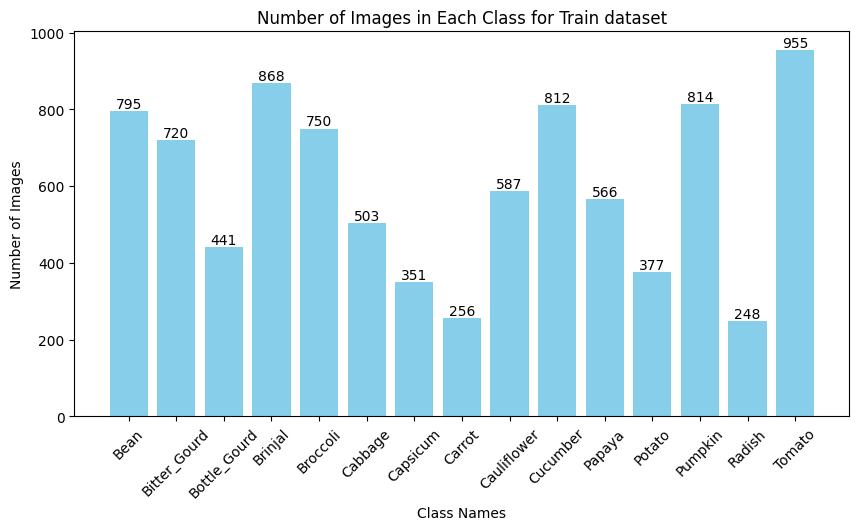

In [8]:
# Initialize a Counter object
counter = Counter()

# Iterate over the dataset and update the counter
for images, labels in train_data_eda:
    counter.update(labels.numpy())

# Extract class names and their corresponding counts
class_names = train_data_eda.class_names
class_counts = [counter[i] for i in range(len(class_names))]

# Plot the bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(class_names, class_counts, color='skyblue')

# Add the count above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class for Train dataset')
plt.xticks(rotation=45)
plt.show()

***
This shows that there is a large difference in images for each class. This means that there is class imbalance involved. For example, there is 248 images for radish while there is 955 images for tomato. Class imbalance can pose challenges during training, as the model may become biased towards the majority classes, leading to poorer performance on minority classes. This is because classes with fewer images may be poorly represented in the dataset, leading to potential difficulties in learning their distinguishing features. Thus, if the dataset is highly imbalanced, models may struggle to generalize well to minority classes, leading to lower overall accuracy.  
***

In [9]:
for X, y in train_data_eda:
    X_train = X
    y_train = y

# Shape of the train dataset
print(X_train.shape)
print(y_train.shape)

(9043, 131, 131, 1)
(9043,)


***
From the output of (9043, 131, 131, 1), we can see that:
- X_train contains 9043 images.
- Each image has dimensions of 131x131 pixels.
- The images are grayscale, as indicated by the last dimension of size 1.


From the output (9043,), we can infer that:
- y_train contains 9043 labels.
- Each label corresponds to one image in X_train.
***

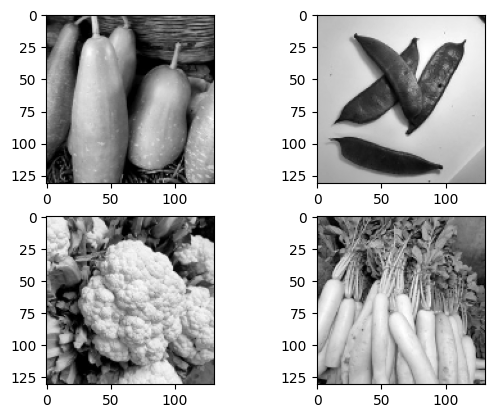

The labels are: ['Bottle_Gourd', 'Bean', 'Cauliflower', 'Radish']


In [10]:
# Plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))

# Show the plot
plt.show()

# Print labels
print('The labels are:', [class_names[label] for label in y_train[:4].numpy()])

***
This shows that the images are 131 by 131 pixels and that the colors is greyscaled. We can also see the sizes of the images is 131 which corresponds to the pixel size we have set for this eda dataset.
***

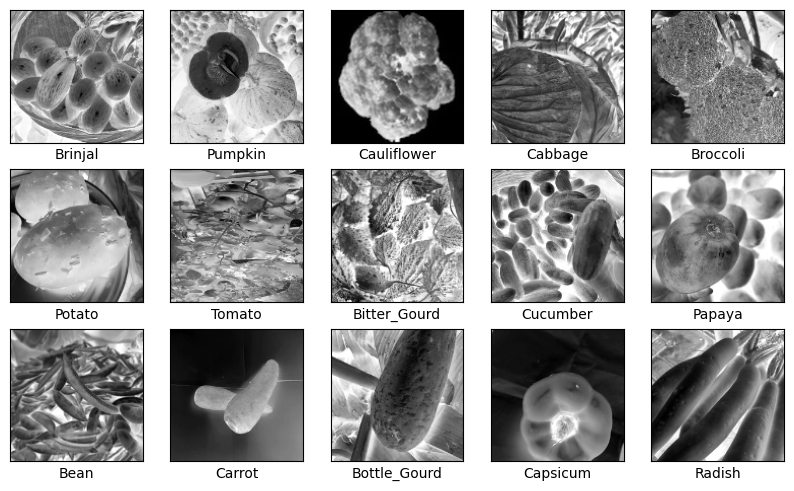

In [11]:
# Convert the dataset to numpy arrays for images and labels
images = []
labels = []
for image_batch, label_batch in train_data_eda:
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())

# Flatten the list of batches into a single numpy array
images = np.concatenate(images)
labels = np.concatenate(labels)

# Shuffle the dataset
shuffle_indices = np.arange(len(labels))
np.random.shuffle(shuffle_indices)
shuffled_images = images[shuffle_indices]
shuffled_labels = labels[shuffle_indices]

# Create a dictionary to store the indices of the first occurrence of each class
first_occurrence_indices = {}

# Iterate over the shuffled dataset
for i, label in enumerate(shuffled_labels):
    # If this is the first occurrence of the class, add its index to the dictionary
    if label not in first_occurrence_indices:
        first_occurrence_indices[label] = i

# Create a new figure
plt.figure(figsize=(10, 10))

# Iterate over the classes and plot one image per class
for i, (label, index) in enumerate(first_occurrence_indices.items()):
    image = shuffled_images[index]
    
    # Plot the image
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)  # Assuming grayscale images

    # Label the image with its class name
    plt.xlabel(class_names[label])

# Show the plot
plt.show()

***
This shows that each vegetables has a unique characteristic/shape or pattern that would allow the machine algorithm learn to do classification.
***

### Analyze the test dataset

In [12]:
# Loads the test dataset
test_data_eda = tf.keras.preprocessing.image_dataset_from_directory(directory='test',
                                                                 color_mode='grayscale',
                                                                 image_size=(pixel_131, pixel_131), # change to pixel_37 for the other resolution
                                                                 batch_size=100000)

Found 3000 files belonging to 15 classes.


***
From this, we can see that there is 3000 images that belong to 15 different types of vegetables in the test dataset.

- We have also made the image with colour into greyscale with "color_mode".
- In this case, we have converted the size from 224 by 224 into size 131 by 131 using "image_size". If we want to change to size 37 by 37, we would use pixel_37 instead of pixel_131. 
***

In [13]:
# Take a look at the class names of the test dataset
test_data_eda.class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

***
From this, we can see the names of the 15 different types of vegetables.
***

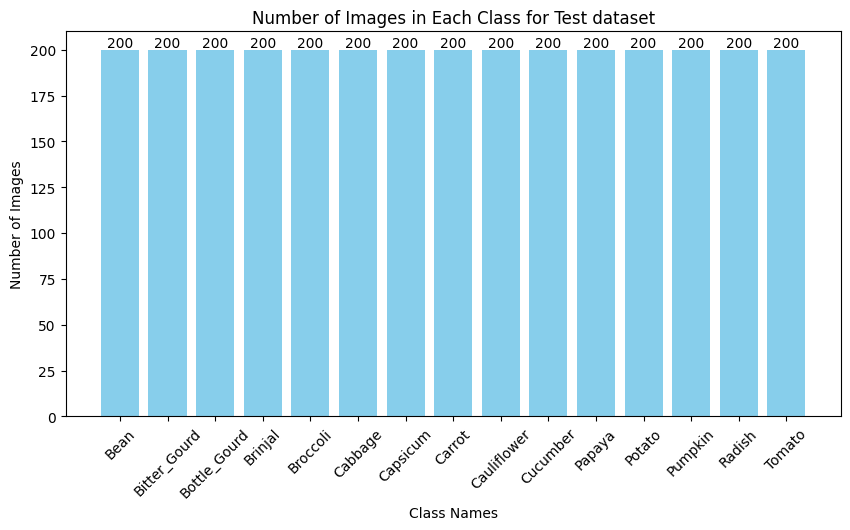

In [14]:
# Initialize a Counter object
counter = Counter()

# Iterate over the dataset and update the counter
for images, labels in test_data_eda:
    counter.update(labels.numpy())

# Extract class names and their corresponding counts
class_names = train_data_eda.class_names
class_counts = [counter[i] for i in range(len(class_names))]

# Plot the bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(class_names, class_counts, color='skyblue')

# Add the count above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class for Test dataset')
plt.xticks(rotation=45)
plt.show()

***
This shows that there is a equal images for each class.
***

In [13]:
for X, y in test_data_eda:
    X_test = X
    y_test = y

# Shape of the test dataset
print(X_test.shape)
print(y_test.shape)

(3000, 131, 131, 1)
(3000,)


***
From the output of (3000, 131, 131, 1), we can see that:
- X_test contains 3000 images.
- Each image has dimensions of 131x131 pixels.
- The images are grayscale, as indicated by the last dimension of size 1.


From the output (3000,), we can infer that:
- y_test contains 3000 labels.
- Each label corresponds to one image in X_test.
***

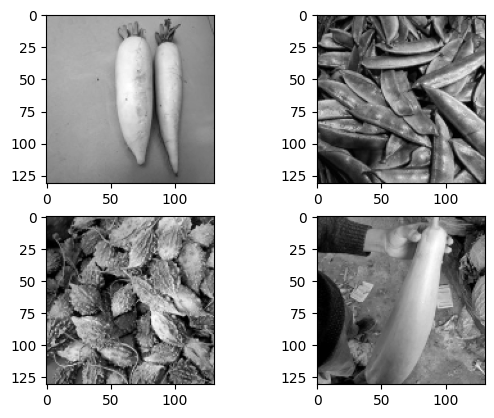

The labels are: ['Radish', 'Bean', 'Bitter_Gourd', 'Bottle_Gourd']


In [14]:
# Plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_test[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_test[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_test[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_test[3], cmap=plt.get_cmap('gray'))

# Show the plot
plt.show()

# Print labels
print('The labels are:', [class_names[label] for label in y_test[:4].numpy()])

***
This shows that the images are 131 by 131 pixels and that the colors is greyscaled. We can also see the sizes of the images is 131 which corresponds to the pixel size we have set for this eda dataset.
***

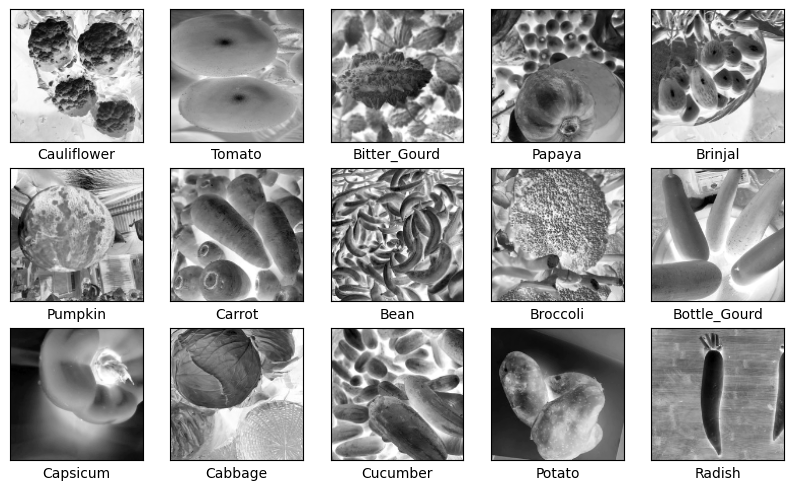

In [15]:
# Convert the dataset to numpy arrays for images and labels
images = []
labels = []
for image_batch, label_batch in test_data_eda:
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())

# Flatten the list of batches into a single numpy array
images = np.concatenate(images)
labels = np.concatenate(labels)

# Shuffle the dataset
shuffle_indices = np.arange(len(labels))
np.random.shuffle(shuffle_indices)
shuffled_images = images[shuffle_indices]
shuffled_labels = labels[shuffle_indices]

# Create a dictionary to store the indices of the first occurrence of each class
first_occurrence_indices = {}

# Iterate over the shuffled dataset
for i, label in enumerate(shuffled_labels):
    # If this is the first occurrence of the class, add its index to the dictionary
    if label not in first_occurrence_indices:
        first_occurrence_indices[label] = i

# Create a new figure
plt.figure(figsize=(10, 10))

# Iterate over the classes and plot one image per class
for i, (label, index) in enumerate(first_occurrence_indices.items()):
    image = shuffled_images[index]
    
    # Plot the image
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)  # Assuming grayscale images

    # Label the image with its class name
    plt.xlabel(class_names[label])

# Show the plot
plt.show()

***
This is to get a general idea of the dataset and the classes we are working with in the test dataset.
***

### Analyze the validation dataset

In [15]:
# Loads the validation dataset
validation_data_eda = tf.keras.preprocessing.image_dataset_from_directory(directory='validation',
                                                                 color_mode='grayscale',
                                                                 image_size=(pixel_131, pixel_131), # change to pixel_37 for the other resolution
                                                                 batch_size=100000)

Found 3000 files belonging to 15 classes.


***
From this, we can see that there is 3000 images that belong to 15 different type of vegetables in the validation dataset.
***

In [16]:
# Take a look at the class names of the validation dataset
validation_data_eda.class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

***
From this, we can see the names of the 15 different types of vegetables.
***

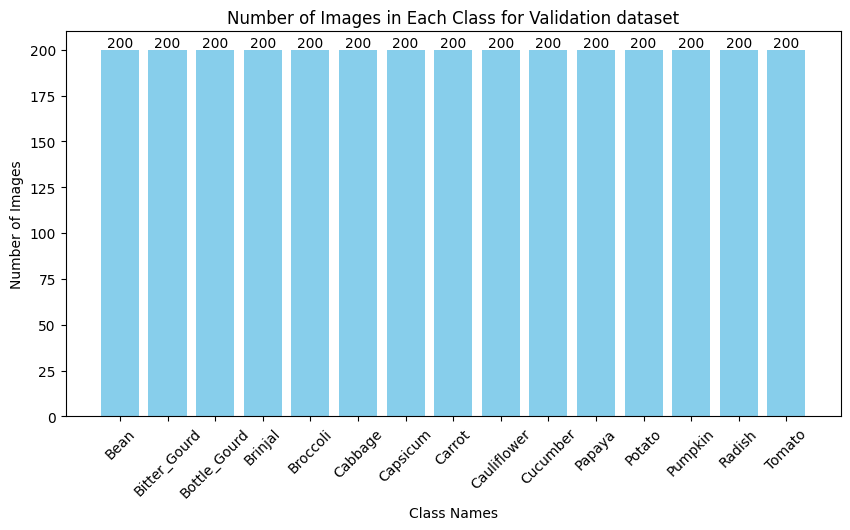

In [18]:
# Initialize a Counter object
counter = Counter()

# Iterate over the dataset and update the counter
for images, labels in validation_data_eda:
    counter.update(labels.numpy())

# Extract class names and their corresponding counts
class_names = train_data_eda.class_names
class_counts = [counter[i] for i in range(len(class_names))]

# Plot the bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(class_names, class_counts, color='skyblue')

# Add the count above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class for Validation dataset')
plt.xticks(rotation=45)
plt.show()

***
This shows that there is no class imbalance in the validation dataset.
***

In [19]:
for X, y in validation_data_eda:
    X_validation = X
    y_validation = y

# Shape of the validation dataset
print(X_validation.shape)
print(y_validation.shape)

(3000, 131, 131, 1)
(3000,)


***
From the output of (3000, 131, 131, 1), we can see that:
- X_validation contains 3000 images.
- Each image has dimensions of 131x131 pixels.
- The images are grayscale, as indicated by the last dimension of size 1.


From the output (3000,), we can infer that:
- y_validation contains 3000 labels.
- Each label corresponds to one image in X_validation.
***

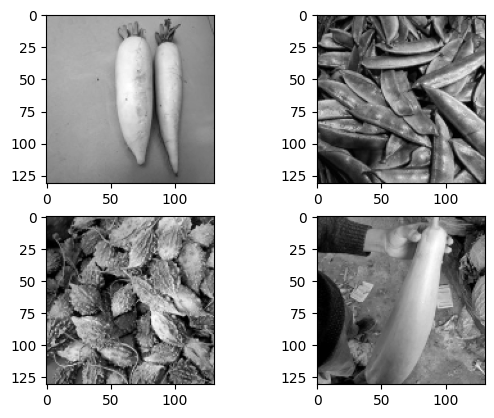

The labels are: ['Radish', 'Bean', 'Bitter_Gourd', 'Bottle_Gourd']


In [20]:
# Plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_test[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_test[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_test[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_test[3], cmap=plt.get_cmap('gray'))

# Show the plot
plt.show()

# Print labels
print('The labels are:', [class_names[label] for label in y_test[:4].numpy()])

***
This shows that the images are 131 by 131 pixels and that the colors is greyscaled.
***

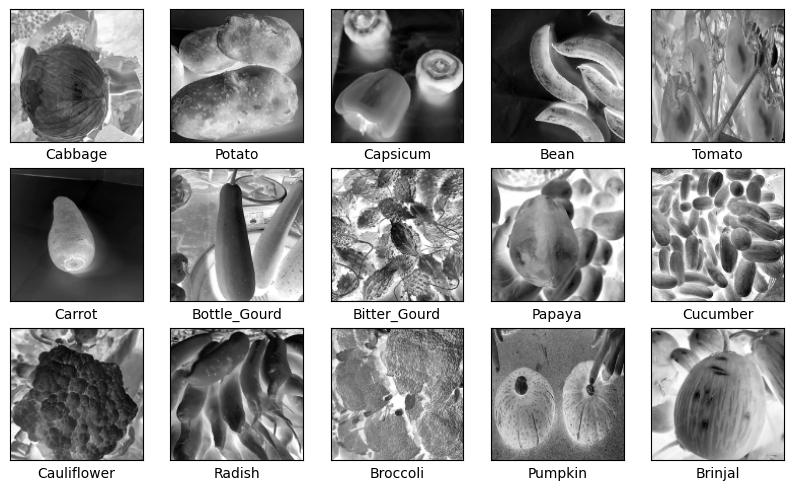

In [21]:
# Convert the dataset to numpy arrays for images and labels
images = []
labels = []
for image_batch, label_batch in validation_data_eda:
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())

# Flatten the list of batches into a single numpy array
images = np.concatenate(images)
labels = np.concatenate(labels)

# Shuffle the dataset
shuffle_indices = np.arange(len(labels))
np.random.shuffle(shuffle_indices)
shuffled_images = images[shuffle_indices]
shuffled_labels = labels[shuffle_indices]

# Create a dictionary to store the indices of the first occurrence of each class
first_occurrence_indices = {}

# Iterate over the shuffled dataset
for i, label in enumerate(shuffled_labels):
    # If this is the first occurrence of the class, add its index to the dictionary
    if label not in first_occurrence_indices:
        first_occurrence_indices[label] = i

# Create a new figure
plt.figure(figsize=(10, 10))

# Iterate over the classes and plot one image per class
for i, (label, index) in enumerate(first_occurrence_indices.items()):
    image = shuffled_images[index]
    
    # Plot the image
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)  # Assuming grayscale images

    # Label the image with its class name
    plt.xlabel(class_names[label])

# Show the plot
plt.show()

***
This is to get a general idea of the dataset and classes we are working with in the validation dataset.
***

## CNN Model for pixel size of 37x37

### Preprocessing

#### Load the dataset

In [22]:
# Loads the train dataset
train_data_37 = tf.keras.preprocessing.image_dataset_from_directory(directory='train',
                                                                 color_mode='grayscale',
                                                                 image_size=(pixel_37, pixel_37), 
                                                                 batch_size=100000)

# Loads the test dataset
test_data_37 = tf.keras.preprocessing.image_dataset_from_directory(directory='test',
                                                                 color_mode='grayscale',
                                                                 image_size=(pixel_37, pixel_37), 
                                                                 batch_size=100000)

# Loads the validation dataset
validation_data_37 = tf.keras.preprocessing.image_dataset_from_directory(directory='validation',
                                                                 color_mode='grayscale',
                                                                 image_size=(pixel_37, pixel_37),
                                                                 batch_size=100000)

Found 9043 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


#### Extract the datasets

In [23]:
for X, y in train_data_37:
    X_train_37 = X
    y_train_37 = y

# Shape of the train dataset
print(X_train_37.shape)
print(y_train_37.shape)

for X, y in test_data_37:
    X_test_37 = X
    y_test_37 = y

 # Shape of the test dataset
print(X_test_37.shape)
print(y_test_37.shape)   

for X, y in validation_data_37:
    X_validation_37 = X
    y_validation_37 = y

# Shape of the validation dataset
print(X_validation_37.shape)
print(y_validation_37.shape)    

(9043, 37, 37, 1)
(9043,)
(3000, 37, 37, 1)
(3000,)
(3000, 37, 37, 1)
(3000,)


#### Normalization

***
Normalization techniques like Batch Normalization are commonly used in CNN models for several reasons:

- Stabilizing Training: 
    - Normalization helps in stabilizing and accelerating the training process. It mitigates the problem of vanishing or exploding gradients during backpropagation by ensuring that inputs to each layer remain within a similar range. This facilitates smoother and faster convergence during training.

- Generalization: 
    - Normalization aids in generalizing the model's learning. By reducing internal covariate shift (the change in the distribution of network activations due to parameter updates), normalization techniques ensure that the network learns features that are applicable across different samples in the dataset, rather than being overly tailored to the training data.

- Regularization: 
    - Normalization acts as a form of regularization. It has a slight regularization effect because it adds noise to the activations during training. This noise can prevent overfitting and improve the model's ability to generalize to unseen data.

- Addressing Internal Covariate Shift: 
    - By normalizing the activations within each layer, normalization techniques like Batch Normalization reduce the internal covariate shift problem. This allows subsequent layers to learn more effectively since they receive inputs that are more stable and consistent.

- Facilitating Higher Learning Rates: 
    - Normalization enables the use of higher learning rates during training, which can accelerate convergence. This is particularly beneficial in deep networks where training without normalization may require very small learning rates to prevent divergence.

Overall, normalization techniques are crucial components in CNN models for improving stability, convergence speed, generalization, and regularization, ultimately leading to better performance on various tasks.
***

In [24]:
# Normalize the train dataset
X_train_37 = X_train_37 / 255.0

# Normalize the test dataset
X_test_37 = X_test_37 / 255.0

# Normalize the validation dataset
X_validation_37 = X_validation_37 / 255.0

#### One-Hot-Encoding

***
One-hot encoding is typically used for categorical variables, especially in the context of classification tasks where the output needs to represent discrete classes. Here's why it's done:

- Representation of Categorical Data: 
    - One-hot encoding is used to represent categorical variables numerically. In classification tasks, the output usually corresponds to different classes or categories. One-hot encoding transforms these categorical labels into a binary format, where each class is represented by a vector with all zeros except for a single one at the index corresponding to the class label.

- Compatibility with Neural Networks: 
    - Neural networks, including CNNs, operate on numerical data. One-hot encoding converts categorical labels into a format that neural networks can process. This enables CNN models to effectively learn relationships and patterns in categorical data through the optimization of numerical parameters during training.

- Loss Calculation: 
    - One-hot encoding facilitates the calculation of the loss function during training. In classification tasks, models typically use categorical cross-entropy loss, which compares the predicted probability distribution (usually obtained through a softmax layer) with the ground truth labels. One-hot encoding ensures that the ground truth labels are in a suitable format for this comparison.

- Output Layer Activation: 
    - In classification tasks, the output layer of the CNN often uses a softmax activation function, which outputs a probability distribution over the classes. One-hot encoding of the target labels allows for easy comparison with the model's predictions, as the predicted probabilities can be directly compared with the one-hot encoded ground truth labels.

- Multi-Class Classification:  
    - One-hot encoding is particularly useful in multi-class classification scenarios where each sample belongs to exactly one class out of several possible classes. It provides a clear and unambiguous representation of class membership, allowing the model to learn to distinguish between different classes effectively.

Overall, one-hot encoding is an essential preprocessing step in CNN models for handling categorical variables, enabling effective training and prediction in classification tasks. In this case, it is needed as the classes of each vegetables are categorical and require to be converted to numericals for classification.
***

In [25]:
# One hot encode outputs
y_train_37 = to_categorical(y_train_37)
y_test_37 = to_categorical(y_test_37)
y_validation_37 = to_categorical(y_validation_37)

num_classes = y_train_37.shape[1]

### Building the initial model for 37x37

In [26]:
# Variable pixel_37 is defined previously
image_size = (pixel_37, pixel_37, 1)  # grayscale image size

# Create model
model = models.Sequential([
    # First convolutional layer
    tf_layers.Conv2D(16, (5, 5), activation='relu', input_shape=image_size),
    tf_layers.MaxPooling2D((2, 2)),
    # Second convolutional layer
    tf_layers.Conv2D(32, (3, 3), activation='relu'),
    tf_layers.MaxPooling2D((2, 2)),
    tf_layers.Dropout(0.2),  # Dropout layer
    # Third convolutional layer
    tf_layers.Conv2D(64, (3, 3), activation='relu'),
    tf_layers.MaxPooling2D((2, 2)),
    # Flatten layer to transition from convolutional to dense layers
    tf_layers.Flatten(),
    # Dense fully connected layers
    tf_layers.Dense(128, activation='relu'),
    tf_layers.Dense(64, activation='relu'),
    # Output layer
    tf_layers.Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 33, 33, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 64)          1

***
Model Architecture Definition:

- The model is defined using the Sequential API, which allows you to create models layer-by-layer.
- The first layer is a convolutional layer (Conv2D) with 16 filters/kernels of size 5x5. The activation function used here is ReLU (Rectified Linear Unit). input_shape=image_size indicates that the input images are expected to have the shape specified by the image_size variable.
- A max-pooling layer (MaxPooling2D) follows, which reduces the spatial dimensions of the feature maps, helps to decrease the computational complexity of the model, by taking the maximum value within each 2x2 window.
Similar layers follow: another convolutional layer with 32 filters of size 3x3, a max-pooling layer, and a dropout layer (Dropout) with a dropout rate of 0.2. 
    - Overfitting occurs when a particular model learns to train on the noise from the training set of the data and does not generalise well to new data. To overcome this problem, a dropout layer is utilised where a few neurons are dropped from the neural network during the training process so that the model learns not to overely on just a few neurons. In keras, this can be specified with the Dropout layer and the percentage of neurons to drop.
    
- Then, there's another convolutional layer with 64 filters of size 3x3, followed by a max-pooling layer.
- The model transitions from convolutional layers to dense layers using a Flatten layer, which flattens the 3D output of the convolutional layers into a 1D vector.
- Two dense fully connected layers (Dense) with 128 and 64 neurons respectively follow, both using ReLU activation.
- Finally, there's an output layer with num_classes neurons (where num_classes is the number of classes in the classification task) and softmax activation, which outputs a probability distribution over the classes.

Definations:

Input Layer:
- Shape: (pixel_37, pixel_37, 1)
- Definition: This layer specifies the shape of the input data. In this case, it defines the input as a grayscale image with height and width equal to pixel_37.

Conv2D Layer:
- Filters: The number of output filters (or feature maps) in the convolution.
- Kernel Size: The dimensions of the convolution window.
- Activation (ReLU): A function that applies the rectified linear unit activation (ReLU(x) = max(0, x)), introducing non-linearity to the model.
- Definition: A convolutional layer that applies a number of convolution filters to the input data to extract spatial features.

MaxPooling2D Layer:
- Pool Size: The dimensions of the pooling window.
- Definition: A downsampling layer that reduces the spatial dimensions (height and width) of the input by taking the maximum value over a defined window, effectively reducing the amount of computation in the network and controlling overfitting.
Dropout Layer:

- Rate: The fraction of input units to drop (set to zero) during training.
- Definition: A regularization layer that randomly sets a fraction of input units to zero at each update during training time, which helps prevent overfitting by ensuring that the network does not rely too much on any individual node.

Flatten Layer:
- Definition: A layer that converts a multidimensional tensor into a one-dimensional vector. This transition is necessary to connect convolutional layers with dense (fully connected) layers.

Dense Layer:
- Units: The number of neurons in the layer.
- Activation (ReLU): An activation function that applies the rectified linear unit function to the input.
- Definition: A fully connected layer where each input is connected to each output by a learnable weight. It allows the network to learn complex representations by combining features learned in previous layers.

Output Layer:

- Units: The number of neurons, typically corresponding to the number of classes in the classification task.
- Activation (Softmax): An activation function that converts the logits (raw prediction values) into probabilities that sum to one.
- Definition: The final layer of the network that produces the classification output. Each neuron corresponds to a class, and the softmax function ensures that the output can be interpreted as probabilities.

Model Compilation: 


Loss Function (Categorical Crossentropy)

- Definition: A loss function used for multi-class classification problems. It measures the difference between the true class labels and the predicted class probabilities, encouraging the model to output probabilities close to the true labels.

Optimizer (Adam):
- Definition: An optimization algorithm that computes adaptive learning rates for each parameter. It combines the advantages of two other popular optimization techniques: AdaGrad and RMSProp.

Metrics (Accuracy):
- Definition: A metric that calculates the proportion of correct predictions. It is a straightforward measure of how often the model's predictions match the true labels.

Model Summary:
- Definition: A detailed overview of the model architecture, including the types of layers, their output shapes, and the number of parameters in each layer. It helps in understanding the structure, depth, and complexity of the model. Calling model.summary() provides a readable summary of the model's layers and parameter counts.


Model Compilation:

- The model is compiled using the compile method.
- The loss function is specified as 'categorical_crossentropy', which is commonly used for multi-class classification problems.
- The optimizer chosen here is 'adam', which is an adaptive learning rate optimization algorithm.
'accuracy' is specified as the metric to monitor during training.
***

### Training and evaluating the model

In [27]:
# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train_37, y_train_37, validation_data=(X_validation_37, y_validation_37), 
                    epochs=100, batch_size=128, verbose=1, callbacks=[early_stopping])

# Final evaluation of the model
scores = model.evaluate(X_test_37, y_test_37, verbose=0)
print("CNN Model Accuracy: {:.2f}%".format(scores[1]*100))

Epoch 1/100
71/71 [==============================] - 5s 11ms/step - loss: 2.6082 - accuracy: 0.1168 - val_loss: 2.6547 - val_accuracy: 0.1350
Epoch 2/100
71/71 [==============================] - 0s 7ms/step - loss: 2.4205 - accuracy: 0.1838 - val_loss: 2.4935 - val_accuracy: 0.1790
Epoch 3/100
71/71 [==============================] - 0s 7ms/step - loss: 2.2623 - accuracy: 0.2385 - val_loss: 2.3444 - val_accuracy: 0.2250
Epoch 4/100
71/71 [==============================] - 0s 7ms/step - loss: 2.1180 - accuracy: 0.2945 - val_loss: 2.2596 - val_accuracy: 0.2687
Epoch 5/100
71/71 [==============================] - 0s 7ms/step - loss: 1.9761 - accuracy: 0.3477 - val_loss: 2.0861 - val_accuracy: 0.3170
Epoch 6/100
71/71 [==============================] - 0s 7ms/step - loss: 1.8632 - accuracy: 0.3917 - val_loss: 1.9186 - val_accuracy: 0.3770
Epoch 7/100
71/71 [==============================] - 0s 7ms/step - loss: 1.7298 - accuracy: 0.4307 - val_loss: 1.8232 - val_accuracy: 0.3993
Epoch 8/100


### Plotting model training history

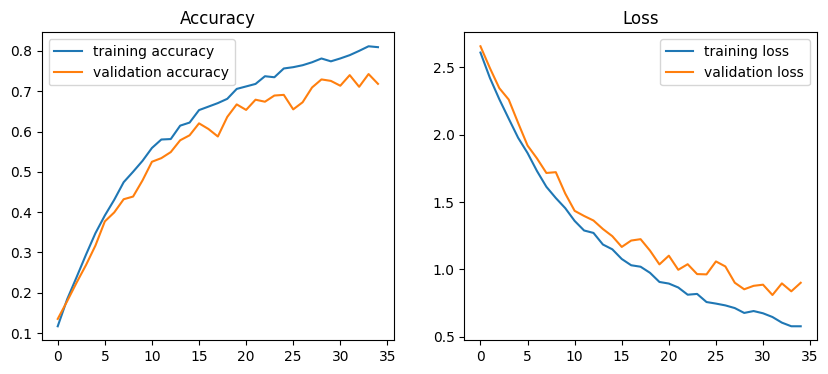

In [28]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Loss')

plt.show()

***
- Accuracy Graph: The graph on the left is labeled “Accuracy”. It has two lines representing ‘training accuracy’ and ‘validation accuracy’. The ‘training accuracy’ line shows how well the model is learning from the training data over time, while the ‘validation accuracy’ line shows how well the model is able to generalize its learning to new, unseen data. If the ‘training accuracy’ is significantly higher than the ‘validation accuracy’, it could indicate overfitting, where the model is too closely fit to the training data and may not perform well on new data.
- Loss Graph: The graph on the right is labeled “Loss”. It also has two lines representing ‘training loss’ and ‘validation loss’. The ‘training loss’ line shows the error rate of the model on the training data, while the ‘validation loss’ line shows the error rate on the validation data. Similar to the accuracy graph, if the ‘training loss’ is significantly lower than the ‘validation loss’, it could suggest overfitting.


The x-axis on both graphs represents the number of epochs, which are complete passes through the entire training dataset. The y-axis on the accuracy graph represents the accuracy of the model, while on the loss graph it represents the error rate.

These graphs are useful for diagnosing issues such as overfitting or underfitting and can guide adjustments in model training for improved performance. In this case, the graphs suggest that the model may be overfitting as it performs better on the training data compared to the validation data. This could be addressed by techniques such as increasing the amount of training data, implementing regularization, or adjusting the complexity of the model.

- The base model already has a very good performance with validation accruracy of 74.87%.
- There is quite a bit of fluctuation in the learning curve for both the train and validation sets.
- There could be overfitting as seen from the difference between training and validation accuracy.
***

### Data augmentation

***
Data augmentation is a technique commonly used in CNN models and other machine learning tasks to artificially increase the size of the training dataset by applying various transformations to the existing data samples. Here are several reasons why data augmentation is employed:

- Increased Dataset Size: 
- In many machine learning tasks, including CNNs, having a larger dataset often leads to better model generalization and performance. However, collecting a large labeled dataset can be expensive and time-consuming. Data augmentation allows you to effectively increase the size of the dataset without collecting additional labeled samples.

- Improved Model Generalization: 
    - By exposing the model to a greater variety of data through data augmentation, you help it learn more robust and invariant features. This reduces overfitting, as the model becomes less sensitive to small variations in the input data and more capable of generalizing to unseen examples.

- Regularization: 
    - Data augmentation acts as a form of regularization by adding noise to the training data. This helps prevent the model from memorizing the training samples and encourages it to learn more meaningful and generalizable features.

- Invariance to Transformations: 
    - Real-world data can exhibit various transformations such as rotation, scaling, translation, flipping, and changes in lighting conditions. Data augmentation enables the model to become invariant to these transformations, making it more robust and applicable to real-world scenarios where such variations occur.

- Balancing Class Distributions: 
    - In classification tasks with imbalanced class distributions, data augmentation can help balance the representation of different classes by generating synthetic examples for the minority classes. This can improve the model's ability to learn discriminative features for all classes and mitigate the bias towards the majority class.

- Domain Adaptation and Transfer Learning: 
    - Data augmentation techniques can also facilitate domain adaptation and transfer learning by simulating data distributions from the target domain or adjusting the source domain data to be more similar to the target domain. This helps improve model performance when deploying the model in real-world settings where the distribution of data may differ from the training data.

Overall, data augmentation is a crucial technique in CNN models for enhancing model generalization, robustness, and performance, especially when labeled data is limited or when the goal is to develop models capable of handling diverse real-world scenarios. In this case, it is good to do data augmenetaion as the data is limited for certain classes of vegeetables and that this model is being done on real life vegetable detection.
***

***
Here are the reasons for using each of these augmentations:

- Rotation Range: 
    - By specifying a rotation range, you allow the training images to be rotated by a random angle within the specified range. This helps the model become invariant to rotation variations, making it more robust to images that are captured from different angles or orientations.

- Width Shift Range and Height Shift Range: 
    - These parameters allow for horizontal and vertical shifting of the images within a specified range. This can simulate variations in object position within the image, helping the model learn to recognize objects regardless of their location within the image.

- Shear Range: 
    - Shearing involves shifting one part of the image in a fixed direction, creating a "shear" effect. By applying random shearing to the training images, you introduce distortions that can help the model learn to recognize objects from different perspectives.

- Zoom Range: 
    - Zooming involves either zooming in or out of the image. By applying random zooming to the training images, you simulate variations in scale, which helps the model become invariant to changes in object size within the image.

- Horizontal Flip: 
    - This parameter allows for randomly flipping the images horizontally. Horizontal flipping can help the model become invariant to left-right orientation variations, which is particularly useful for tasks where the orientation of objects is not significant.

- Fill Mode: 
    - This parameter determines the strategy used to fill in newly created pixels that may be introduced during augmentation, such as when performing rotations or shifts. 'Nearest' mode fills new pixels with the nearest pixel value from the original image, which helps maintain the overall appearance of the image.

Overall, by applying these augmentation techniques, the model has a more diverse and comprehensive training dataset, which helps improve its ability to generalize and perform well on unseen data. These augmentations also help the model become more robust to various transformations and variations that may be present in real-world images.
***

Original dataset shape: (9043, 37, 37, 1) (9043,)
Shape after augmentation: (14325, 37, 37, 1) (14325,)
Class counts after balancing: {0: 955, 1: 955, 2: 955, 3: 955, 4: 955, 5: 955, 6: 955, 7: 955, 8: 955, 9: 955, 10: 955, 11: 955, 12: 955, 13: 955, 14: 955}
Epoch 1/100
448/448 [==============================] - 3s 6ms/step - loss: 1.3085 - accuracy: 0.5797 - val_loss: 1.0882 - val_accuracy: 0.6370
Epoch 2/100
448/448 [==============================] - 3s 6ms/step - loss: 1.1377 - accuracy: 0.6357 - val_loss: 1.0241 - val_accuracy: 0.6640
Epoch 3/100
448/448 [==============================] - 3s 6ms/step - loss: 1.0652 - accuracy: 0.6545 - val_loss: 1.0427 - val_accuracy: 0.6607
Epoch 4/100
448/448 [==============================] - 3s 6ms/step - loss: 0.9968 - accuracy: 0.6771 - val_loss: 0.9076 - val_accuracy: 0.7097
Epoch 5/100
448/448 [==============================] - 3s 6ms/step - loss: 0.9351 - accuracy: 0.6931 - val_loss: 0.8552 - val_accuracy: 0.7243
Epoch 6/100
448/448 [====

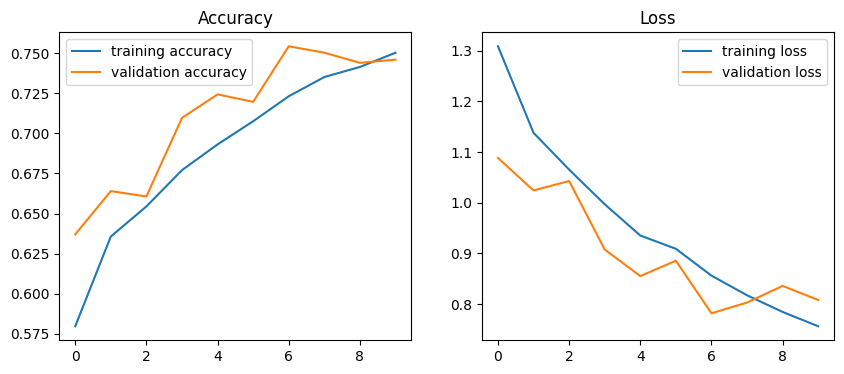

In [29]:
# Define augmentation techniques
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment a dataset to a target size
def augment_to_target_size(images, labels, target_size_per_class):
    unique_labels, counts = np.unique(labels, return_counts=True)
    class_indices = {label: np.where(labels == label)[0] for label in unique_labels}

    new_images, new_labels = [], []

    for label, count in zip(unique_labels, counts):
        indices = class_indices[label]
        class_images = images[indices]
        
        if count < target_size_per_class:
            additional_images_needed = target_size_per_class - count
            i = 0

            while additional_images_needed > 0:
                image = class_images[i % count]
                augmented_image = datagen.random_transform(image)
                new_images.append(augmented_image)
                new_labels.append(label)
                additional_images_needed -= 1
                i += 1

        # Add original images
        new_images.extend(class_images)
        new_labels.extend([label] * count)

    return np.array(new_images), np.array(new_labels)

# Convert TensorFlow dataset to numpy arrays
images_list, labels_list = [], []

for X, y in train_data_37:
    images_list.append(X.numpy())
    labels_list.append(y.numpy())

X_train_37 = np.concatenate(images_list)
y_train_37 = np.concatenate(labels_list)

# Print original dataset shape for verification
print("Original dataset shape:", X_train_37.shape, y_train_37.shape)

# Balance the dataset
max_class_count = np.max(np.bincount(y_train_37))
target_size_per_class = max_class_count

X_train_37_balanced, y_train_37_balanced = augment_to_target_size(X_train_37, y_train_37, target_size_per_class)

# Verify shapes after augmentation
print("Shape after augmentation:", X_train_37_balanced.shape, y_train_37_balanced.shape)

# Shuffle the dataset
indices = np.arange(len(y_train_37_balanced))
np.random.shuffle(indices)
X_train_37_balanced = X_train_37_balanced[indices]
y_train_37_balanced = y_train_37_balanced[indices]

# Normalize the dataset
X_train_37_balanced = X_train_37_balanced / 255.0

# One hot encode outputs
y_train_37_balanced = to_categorical(y_train_37_balanced)

# Convert back to TensorFlow dataset
balanced_dataset = tf.data.Dataset.from_tensor_slices((X_train_37_balanced, y_train_37_balanced))
train_data_37_balanced = balanced_dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Check the balanced dataset
class_counts = {label: np.sum(np.argmax(y_train_37_balanced, axis=1) == label) for label in np.unique(np.argmax(y_train_37_balanced, axis=1))}
print("Class counts after balancing:", class_counts)

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(train_data_37_balanced, validation_data=(X_validation_37, y_validation_37), 
                    epochs=100, verbose=1, callbacks=[early_stopping])

# Final evaluation of the model
scores = model.evaluate(X_test_37, y_test_37, verbose=0)
print("CNN Model Accuracy: {:.2f}%".format(scores[1]*100))

# Plot training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Loss')

plt.show()

***
As seen above, I have balanced out the class count of each vegetable to be 955, such that the machine would have lesser bias when training on more of a certain vegetable class. Instead of feeding in the original data, the dataset with augmentation is fed into the model. This increases our training data from 9043 to around 14325 allowing the model to have more images to work with. As seen from the graph above, the validation accuracy is higher than training accuracy which shows that underfitting is present.


 However, this is only seen for around 6 epochs before the training accuracy starts to overtake the validation accuracy, which means that overfitting is starting to occur. If the validation accuracy is consistently higher than the training accuracy, it might be an indication that the model is underfitting the training data. Underfitting occurs when a model is too simple to capture the underlying structure of the data. The model has high bias and low variance, which means it consistently and systematically misrepresents the data, leading to low accuracy on both the training and validation sets. 

However, it’s also worth noting that sometimes, especially early in training, the validation accuracy can be higher than the training accuracy because of the following reasons:

- Dropout:
    -  Dropout is a regularization technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass. If you’re using dropout in your model, it’s turned off when calculating the validation loss. So if dropout is helping prevent overfitting, your validation results could be better than your training results.
- Batch Normalization:
    - Batch normalization is a technique for improving the speed, performance, and stability of artificial neural networks. It is used to normalize the input layer by adjusting and scaling the activations. Similar to Dropout, if you’re using batch normalization, the statistics for the batch normalization layers are calculated differently for training and validation. This could also lead to better performance on the validation set.
- Size of Validation Set: 
    - If your validation set is small, the validation scores can have high variance, causing them to occasionally be better than the training scores.


If we compare before and after data augmentaion, there is less of a overfit as seen from the smaller difference between training and validation accuracy. Before augmenetation and after augmenetation, the accuracy increased from a 74.87% to a 75.77%. Since data augmentation helps to reduce overfitting and increases model accuracy, we would be using it for the next models.

***

### Model improvements (Hyperparemeter tuning)

***
Hyperparameter tuning in Convolutional Neural Networks (CNNs) is crucial for improving model performance. Hyperparameters are settings that control the training process and the structure of the network, and they need to be set before the learning process begins.

Key Hyperparameters in CNNs:

- Number of layers:
    - Definition: This refers to the total number of layers in a neural network model. Layers can include convolutional layers, pooling layers, fully connected (dense) layers, dropout layers, and more.
    - Importance: The number of layers in a neural network determines its depth. Deeper networks can model more complex functions and learn more abstract representations of data, but they also require more computational resources and are more challenging to train.

- Number of neurons:
    - Definition: This refers to the number of neurons (or units) in a specific layer of the neural network, typically in dense (fully connected) layers.
    - Importance: The number of neurons in a layer affects the capacity of the network to learn patterns from the data. More neurons can capture more details but also increase the risk of overfitting and computational cost.

- Activation
    - Definition: An activation function is applied to the output of a neuron in a layer to introduce non-linearity into the network. Common activation functions include ReLU (Rectified Linear Unit), sigmoid, and softmax.
    - Importance: Activation functions allow neural networks to learn and model complex data by introducing non-linearities. Without activation functions, the network would behave like a linear regression model regardless of its depth.    

- Learning Rate: 
    - Definition: The learning rate is a hyperparameter that controls how much the model's weights are adjusted in response to the gradient of the loss function with respect to the weights. It determines the step size during optimization.
    - Importance: A higher learning rate can speed up training but may cause the model to converge too quickly to a suboptimal solution. A lower learning rate provides more precise updates but can slow down training and risk getting stuck in local minima.

- Batch Size:
    - Definition: The batch size is the number of training samples used in one forward/backward pass during training. The entire training dataset is divided into smaller batches, and the model parameters are updated after each batch.
    - Importance: The batch size affects the stability and speed of training. Smaller batch sizes lead to more frequent updates and can help escape local minima, but they might be noisier and require more epochs to converge. Larger batch sizes provide more stable updates but require more memory and might take longer per epoch.

- Number of Epochs: 
    - While not normally falling under hyperparameter tuning, the number of times the entire training dataset passes through the network. The appropriate number of epochs is often found through early stopping techniques, which monitor validation performance and halt training when performance stops improving.

- Optimizer: 
    - Definition: An optimizer is an algorithm used to update the weights of the network in order to minimize the loss function. Common optimizers include SGD (Stochastic Gradient Descent), Adam, RMSprop, and Adagrad.
    - Importance: The choice of optimizer can significantly affect the training process and the performance of the model. Different optimizers have different strategies for adjusting the learning rate and handling gradients, which can influence how quickly and effectively the model converges.
    
The algorithm used to update network weights based on the gradients. Common optimizers include:

- SGD (Stochastic Gradient Descent)
    - Definition: Updates the model parameters based on the gradient of the loss function for each batch.
    - Pros: Simple and effective for many problems.
    - Cons: Can be slow to converge and sensitive to learning rate.
- Adam
    - Definition: Combines the benefits of two other extensions of SGD (AdaGrad and RMSprop). It maintains separate learning rates for each parameter and adjusts them based on the first and second moments of the gradients.
    - Pros: Fast convergence, well-suited for problems with large data and parameters.
    - Cons: Requires more memory, may need careful tuning.
- RMSprop
    - Definition: An optimizer that divides the learning rate by an exponentially decaying average of squared gradients.
    - Pros: Efficient, handles non-stationary objectives well.
    - Cons: Requires careful tuning of hyperparameters.
- Adadelta
    - Definition: An optimizer that adapts the learning rate for each parameter based on the magnitude of gradients.
    - Pros: Good for sparse data.
    - Cons: Learning rate can become excessively small over time.


Network Architecture:

- Number of Layers: 
    - More layers can capture more complex patterns but can also lead to overfitting.
- Number of Filters: 
    - More filters can capture more features but increase computational cost.
- Kernel Size: 
    - Typically 3x3 or 5x5. Smaller kernels capture fine details, while larger kernels capture broader patterns.
- Stride and Padding: 
    - Stride controls the step size of the convolution operation, while padding helps preserve spatial dimensions.
- Dropout Rate: 
    - Used to prevent overfitting by randomly setting a fraction of input units to zero at each update during training. Common values range from 0.2 to 0.5.

- Activation Functions: Functions applied to introduce non-linearity. Common choices include:
    - ReLU
        - Use: Commonly used in hidden layers of neural networks.
        - Benefits: Computationally efficient, helps mitigate the vanishing gradient problem.
    - Leaky ReLU
    - Tanh
    - Sigmoid
        - Use: Often used in the output layer for binary classification problems.
        - Benefits: Outputs values between 0 and 1, useful for probability estimation.

    - Elu


Methods for Hyperparameter Tuning:
- Grid Search: 
    - Exhaustively searching through a manually specified subset of the hyperparameter space. It's thorough but computationally expensive.

- Random Search: 
    - Randomly sampling the hyperparameter space. Often more efficient than grid search as it can cover a larger area of the hyperparameter space.

- Bayesian Optimization: 
    - Builds a probabilistic model of the function mapping hyperparameters to the objective to find the most promising hyperparameters to evaluate next.

    

***

In [30]:
# Function to create the Keras model
def create_model(num_layers=3, num_neurons=128, activation='relu', optimizer='adam', learning_rate=0.001):
    model = models.Sequential()
    model.add(tf_layers.Conv2D(16, (5, 5), activation=activation, input_shape=X_train_37_balanced.shape[1:]))
    model.add(tf_layers.MaxPooling2D((2, 2)))
    
    for _ in range(num_layers - 1):
        model.add(tf_layers.Conv2D(num_neurons, (3, 3), activation=activation))
        model.add(tf_layers.MaxPooling2D((2, 2)))
        model.add(tf_layers.Dropout(0.2))
    
    model.add(tf_layers.Flatten())
    model.add(tf_layers.Dense(128, activation=activation))
    model.add(tf_layers.Dense(64, activation=activation))
    model.add(tf_layers.Dense(len(np.unique(np.argmax(y_train_37_balanced, axis=1))), activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Wrap the Keras model with KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

param_dist = {
    'num_layers': [2, 3, 4, 5, 6, 7],
    'num_neurons': [32, 64, 128, 256],
    'activation': ['relu', 'tanh', 'sigmoid', 'elu'],
    'batch_size': [64, 128, 256, 512],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.5],  # Expanded range for learning rate
    'optimizer': ['adam', 'sgd', 'rmsprop', 'adadelta']
}

# Perform the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2)

# Fit the RandomizedSearchCV
random_search.fit(X_train_37_balanced, y_train_37_balanced, validation_data=(X_validation_37, y_validation_37))

# Print the best parameters and best score
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END activation=elu, batch_size=512, learning_rate=0.001, num_layers=3, num_neurons=32, optimizer=adadelta; total time=   1.1s
[CV] END activation=elu, batch_size=512, learning_rate=0.001, num_layers=3, num_neurons=32, optimizer=adadelta; total time=   1.0s
[CV] END activation=elu, batch_size=512, learning_rate=0.001, num_layers=3, num_neurons=32, optimizer=adadelta; total time=   1.0s
[CV] END activation=elu, batch_size=512, learning_rate=0.001, num_layers=2, num_neurons=32, optimizer=adadelta; total time=   0.9s
[CV] END activation=elu, batch_size=512, learning_rate=0.001, num_layers=2, num_neurons=32, optimizer=adadelta; total time=   0.9s
[CV] END activation=elu, batch_size=512, learning_rate=0.001, num_layers=2, num_neurons=32, optimizer=adadelta; total time=   1.2s
[CV] END activation=sigmoid, batch_size=512, learning_rate=0.001, num_layers=2, num_neurons=256, optimizer=rmsprop; total time=   1.4s
[CV] END activatio

***
As seen above, I have just found the "best" hyperparameters for this CNN model. I have used RandomSearchCV in order to find the best hyperparameter settings from specified distributions in param_dist and then evaluated them. 

I have chosen RandomSearchCV in this case as:
- Computational Constraints: 
    - In scenarios with limited computational power or when dealing with very large datasets and complex models, Randomized Search provides a more feasible approach to hyperparameter tuning. In this case, as I spend a majority of my time coding this on my laptop, I needed to take note of the computing power.
- Efficiency and speed:
    - Randomized Search samples a fixed number of hyperparameter combinations randomly from the specified distributions. This often requires fewer evaluations compared to Grid Search, which exhaustively evaluates all possible combinations in a predefined grid. It thus evaluates fewer combinations, it is generally faster, making it more practical for models with long training times.
- Coverage of the Search Space
    - Broader Exploration: Randomized Search can explore a larger and more diverse set of hyperparameter values, especially when the search space is large. This allows it to potentially discover good combinations that might be missed by Grid Search. By sampling randomly, Randomized Search can sometimes find hyperparameter values in regions of the search space that Grid Search, which samples systematically, may not cover well.        

The "best" hyperparameter for this model would be Best: 0.159581 using {'optimizer': 'adam', 'num_neurons': 256, 'num_layers': 3, 'learning_rate': 0.0001, 'batch_size': 64, 'activation': 'relu'}. We would be fitting the best parameters into a model in order to see if hyperparameter tuning did improve the CNN model accuracy.

***

### Putting the best parameters into the model

In [31]:
# Extract the best parameters
best_params = random_search.best_params_
best_num_layers = best_params['num_layers']
best_num_neurons = best_params['num_neurons']
best_activation = best_params['activation']
best_optimizer = best_params['optimizer']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']

# Create model
model = models.Sequential()

# Add convolutional layers based on the best number of layers
model.add(tf_layers.Conv2D(16, (5, 5), activation='relu', input_shape=image_size))
model.add(tf_layers.MaxPooling2D((2, 2)))

for _ in range(best_num_layers - 1):
    model.add(tf_layers.Conv2D(best_num_neurons, (3, 3), activation=best_activation))
    model.add(tf_layers.MaxPooling2D((2, 2)))
    model.add(tf_layers.Dropout(0.2))

# Flatten layer
model.add(tf_layers.Flatten())

# Dense layers
model.add(tf_layers.Dense(128, activation=best_activation))
model.add(tf_layers.Dense(64, activation=best_activation))
model.add(tf_layers.Dense(num_classes, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', 
              optimizer=best_optimizer,
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 33, 33, 16)        416       
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_103 (Conv2D)         (None, 14, 14, 256)       37120     
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 7, 7, 256)        0         
 g2D)                                                            
                                                                 
 dropout_54 (Dropout)        (None, 7, 7, 256)         0         
                                                                 
 conv2d_104 (Conv2D)         (None, 5, 5, 256)       

***
Above is the model summary with the hyperparameters that were found out during tuning.
***

### Training and evaluating the model

In [32]:
# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train_37_balanced, y_train_37_balanced, validation_data=(X_validation_37, y_validation_37), 
                    epochs=100, batch_size=128, verbose=1, callbacks=[early_stopping])

# Final evaluation of the model
scores = model.evaluate(X_test_37, y_test_37, verbose=0)
print("CNN Model Accuracy: {:.2f}%".format(scores[1] * 100))

Epoch 1/100
112/112 [==============================] - 2s 11ms/step - loss: 2.5566 - accuracy: 0.1284 - val_loss: 2.3430 - val_accuracy: 0.2273
Epoch 2/100
112/112 [==============================] - 1s 8ms/step - loss: 2.1590 - accuracy: 0.2861 - val_loss: 2.0446 - val_accuracy: 0.3403
Epoch 3/100
112/112 [==============================] - 1s 9ms/step - loss: 1.8894 - accuracy: 0.3787 - val_loss: 1.6410 - val_accuracy: 0.4673
Epoch 4/100
112/112 [==============================] - 1s 8ms/step - loss: 1.6693 - accuracy: 0.4509 - val_loss: 1.8630 - val_accuracy: 0.3917
Epoch 5/100
112/112 [==============================] - 1s 8ms/step - loss: 1.5197 - accuracy: 0.4955 - val_loss: 1.3033 - val_accuracy: 0.5793
Epoch 6/100
112/112 [==============================] - 1s 8ms/step - loss: 1.4203 - accuracy: 0.5403 - val_loss: 1.1545 - val_accuracy: 0.6280
Epoch 7/100
112/112 [==============================] - 1s 8ms/step - loss: 1.2915 - accuracy: 0.5788 - val_loss: 1.0384 - val_accuracy: 0.662

In [33]:
# Save model weights
model.save_weights('./model_37.h5')

### Plotting model training history

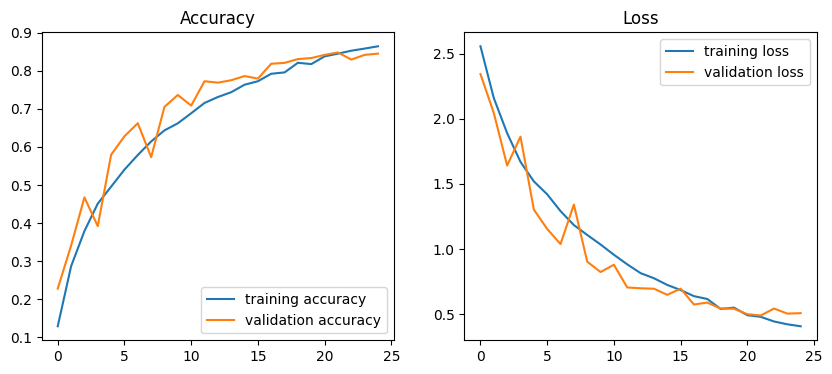

In [34]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Loss')

plt.show()

***
After utilising the data augmentated dataset and inputing the best hyperparameter parameters into the model, we have achieved an increased accuracy of 74.87% compared to the intial model accuracy of 81.09%. The overfitting is also reduced as the y-axis has a difference of less than 0.1 for accuracy and error.
***

## Summary of CNN Model for pixel size of 37x37

***
- Initial model:
    - The base model on the original dataset has a good initial performance of model accuracy about 74.87%.
    - From the graph, there is some overfitting involved as the training accuracy line is above the validation accuracy line.
    - Data augmenetation could be done to help with overfitting and hyperparameter tuning could be done to help with increasing the model accuracy even more.

- Model after data augmentation:
    - The base model on the data augmeneted train dataset has a higher model accuracy of around 75.77%, which decreased from 74.87% in the inital model without data augmentation.
    - From the graph, there is large underfitting involved at the start of training but it improved towards the end where it became overfitted. 
    - Early stop helped to stop the epochs in order to prevent overfitting on the training dataset.

- Final model after data augmenetaion and hyper parameter tuning:
    - We have used RandomSearchCV to search for the "best" hyperparameters to be used with the data augmented train dataset.
    - The hyperparameter tuned model with data augmented train dataset has an accuracy of 85.53%.
    - From the graph, we can see that the overfitting and underfitting has been reduced significantly from the initial model. 
    - The initial model has a difference of around 1.5 betweeen training and validation accuracy while there is about a differnce of 1 between training and validation loss. The final model has a difference of around 0.2 between training and validation accuracy while a difference of around 0.3 between training and validation loss.

Overall, data augmentation and hyperparameter tuning has been effective in allowing model to better train on the 37x37 pixel sized images, through an overall increase of CNN model accuracy, a lower CNN model error and the significant reduction of overfitting or underfitting.
***

## CNN Model for pixel size of 131x131

### Preprocessing

#### Load the dataset

In [52]:
# Loads the train dataset
train_data_131 = tf.keras.preprocessing.image_dataset_from_directory(directory='train',
                                                                 color_mode='grayscale',
                                                                 image_size=(pixel_131, pixel_131), 
                                                                 batch_size=100000)

# Loads the test dataset
test_data_131 = tf.keras.preprocessing.image_dataset_from_directory(directory='test',
                                                                 color_mode='grayscale',
                                                                 image_size=(pixel_131, pixel_131), 
                                                                 batch_size=100000)

# Loads the validation dataset
validation_data_131 = tf.keras.preprocessing.image_dataset_from_directory(directory='validation',
                                                                 color_mode='grayscale',
                                                                 image_size=(pixel_131, pixel_131),
                                                                 batch_size=100000)

Found 9043 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


#### Extract the datasets

In [53]:
for X, y in train_data_131:
    X_train_131 = X
    y_train_131 = y

# Shape of the train dataset
print(X_train_131.shape)
print(y_train_131.shape)

for X, y in test_data_131:
    X_test_131 = X
    y_test_131 = y

 # Shape of the test dataset
print(X_test_131.shape)
print(y_test_131.shape)   

for X, y in validation_data_131:
    X_validation_131 = X
    y_validation_131 = y

# Shape of the validation dataset
print(X_validation_131.shape)
print(y_validation_131.shape)    

(9043, 131, 131, 1)
(9043,)
(3000, 131, 131, 1)
(3000,)
(3000, 131, 131, 1)
(3000,)


#### Normalization

In [54]:
# Normalize the train dataset
X_train_131 = X_train_131 / 255.0

# Normalize the test dataset
X_test_131 = X_test_131 / 255.0

# Normalize the validation dataset
X_validation_131 = X_validation_131 / 255.0

#### One-Hot-Encoding

In [55]:
# One hot encode outputs
y_train_131 = to_categorical(y_train_131)
y_test_131 = to_categorical(y_test_131)
y_validation_131 = to_categorical(y_validation_131)

num_classes = y_train_131.shape[1]

### Building the base model

In [56]:
# Variable pixel_131 is defined previously
image_size = (pixel_131, pixel_131, 1)  # grayscale image size

# Create model
model = models.Sequential([
    # First convolutional layer
    tf_layers.Conv2D(16, (5, 5), activation='relu', input_shape=image_size),
    tf_layers.MaxPooling2D((2, 2)),
    # Second convolutional layer
    tf_layers.Conv2D(32, (3, 3), activation='relu'),
    tf_layers.MaxPooling2D((2, 2)),
    tf_layers.Dropout(0.2),  # Dropout layer
    # Third convolutional layer
    tf_layers.Conv2D(64, (3, 3), activation='relu'),
    tf_layers.MaxPooling2D((2, 2)),
    # Flatten layer to transition from convolutional to dense layers
    tf_layers.Flatten(),
    # Dense fully connected layers
    tf_layers.Dense(128, activation='relu'),
    tf_layers.Dense(64, activation='relu'),
    # Output layer
    tf_layers.Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_240 (Conv2D)         (None, 127, 127, 16)      416       
                                                                 
 max_pooling2d_216 (MaxPooli  (None, 63, 63, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_241 (Conv2D)         (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_217 (MaxPooli  (None, 30, 30, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_148 (Dropout)       (None, 30, 30, 32)        0         
                                                                 
 conv2d_242 (Conv2D)         (None, 28, 28, 64)      

***
- image_size: Specifies the shape of the input images. pixel_131 is a variable (defined previously) representing the height and width of the image. The third dimension 1 indicates that the images are in grayscale (single color channel).

Model Architecture Definition:
- models.Sequential(): This defines a linear stack of layers, where each layer has exactly one input tensor and one output tensor.
- First Convolutional Layer
    -   tf_layers.Conv2D(16, (5, 5), activation='relu', input_shape=image_size):
    - Conv2D: Applies 2D convolutional filters to the input image.
    - 16: Number of filters.
    - (5, 5): Size of each filter.
    - activation='relu': Activation function to apply after convolution.
    - input_shape=image_size: Shape of the input images.
    - tf_layers.MaxPooling2D((2, 2)): Downsamples the input by taking the maximum value over a 2x2 window.
- Second Convolutional Layer
    - tf_layers.Conv2D(32, (3, 3), activation='relu'): Similar to the first layer, but with 32 filters of size 3x3.
    - tf_layers.MaxPooling2D((2, 2)): Again, performs max pooling with a 2x2 window.
    - tf_layers.Dropout(0.2): Randomly sets 20% of the input units to 0 during training to prevent overfitting.
- Third Convolutional Layer
    - tf_layers.Conv2D(64, (3, 3), activation='relu'): 64 filters of size 3x3.
    - tf_layers.MaxPooling2D((2, 2)): Max pooling with a 2x2 window.
- Transition from Convolutional to Dense Layers
    - tf_layers.Flatten(): Flattens the input to a 1D vector, preparing it for the fully connected layers.
- Dense Fully Connected Layers
    - tf_layers.Dense(128, activation='relu'): Fully connected layer with 128 units.
    - tf_layers.Dense(64, activation='relu'): Fully connected layer with 64 units.
- Output Layer
    - tf_layers.Dense(num_classes, activation='softmax'): Final layer with num_classes units (number of output classes), using the softmax activation function to produce a probability distribution over the classes.

- Compiling steps:
    - loss='categorical_crossentropy': Loss function for multi-class classification.
    - optimizer='adam': Adam optimizer, which is an adaptive learning rate optimization algorithm.
    - metrics=['accuracy']: Metric to evaluate the model performance.    
***

#### Training and evaluating the model

In [57]:
# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train_131, y_train_131, validation_data=(X_validation_131, y_validation_131), 
                    epochs=100, batch_size=128, verbose=1, callbacks=[early_stopping])

# Final evaluation of the model
scores = model.evaluate(X_test_131, y_test_131, verbose=0)
print("CNN Model Accuracy: {:.2f}%".format(scores[1]*100))

Epoch 1/100
71/71 [==============================] - 2s 22ms/step - loss: 2.4616 - accuracy: 0.1879 - val_loss: 2.2303 - val_accuracy: 0.2917
Epoch 2/100
71/71 [==============================] - 1s 19ms/step - loss: 1.7438 - accuracy: 0.4524 - val_loss: 1.7839 - val_accuracy: 0.4133
Epoch 3/100
71/71 [==============================] - 1s 18ms/step - loss: 1.4156 - accuracy: 0.5519 - val_loss: 1.4318 - val_accuracy: 0.5460
Epoch 4/100
71/71 [==============================] - 1s 18ms/step - loss: 1.1526 - accuracy: 0.6329 - val_loss: 1.2243 - val_accuracy: 0.6097
Epoch 5/100
71/71 [==============================] - 1s 18ms/step - loss: 0.9938 - accuracy: 0.6788 - val_loss: 1.1839 - val_accuracy: 0.6287
Epoch 6/100
71/71 [==============================] - 1s 19ms/step - loss: 0.8411 - accuracy: 0.7355 - val_loss: 0.9386 - val_accuracy: 0.6967
Epoch 7/100
71/71 [==============================] - 1s 19ms/step - loss: 0.6598 - accuracy: 0.7970 - val_loss: 1.0207 - val_accuracy: 0.6740
Epoch 

#### Plotting model training history

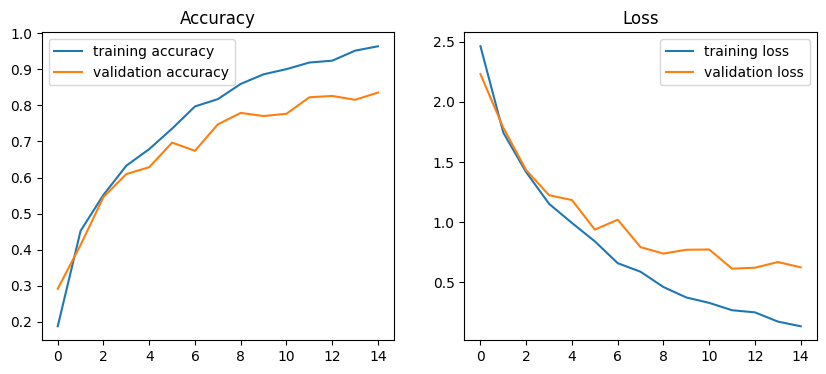

In [58]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Loss')

plt.show()

***
- The base model has around 82.90% which is a good start.
- There is overfitting as the training accuracy is higher than the validation accuracy by around 0.5.
***

### Data augmentation

Original dataset shape: (9043, 131, 131, 1) (9043,)
Shape after augmentation: (14325, 131, 131, 1) (14325,)
Class counts after balancing: {0: 955, 1: 955, 2: 955, 3: 955, 4: 955, 5: 955, 6: 955, 7: 955, 8: 955, 9: 955, 10: 955, 11: 955, 12: 955, 13: 955, 14: 955}
Epoch 1/100
448/448 [==============================] - 4s 8ms/step - loss: 0.9553 - accuracy: 0.6968 - val_loss: 0.6625 - val_accuracy: 0.7933
Epoch 2/100
448/448 [==============================] - 4s 8ms/step - loss: 0.6401 - accuracy: 0.7963 - val_loss: 0.7280 - val_accuracy: 0.7767
Epoch 3/100
448/448 [==============================] - 4s 8ms/step - loss: 0.4947 - accuracy: 0.8429 - val_loss: 0.5282 - val_accuracy: 0.8427
Epoch 4/100
448/448 [==============================] - 4s 8ms/step - loss: 0.3980 - accuracy: 0.8669 - val_loss: 0.5696 - val_accuracy: 0.8310
Epoch 5/100
448/448 [==============================] - 4s 8ms/step - loss: 0.3096 - accuracy: 0.8984 - val_loss: 0.6876 - val_accuracy: 0.8123
Epoch 6/100
448/448 [

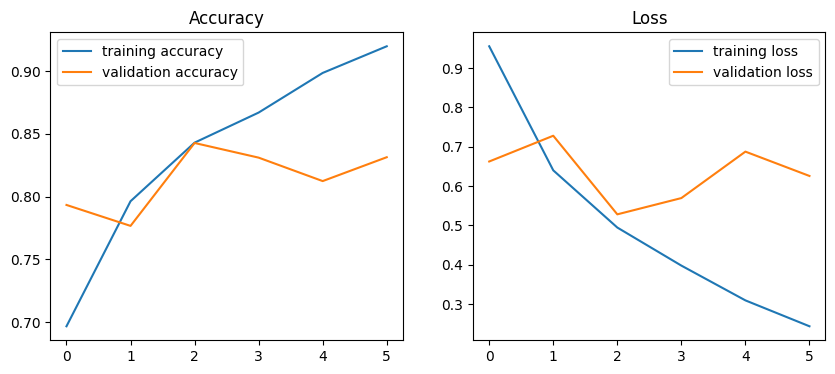

In [59]:
# Define augmentation techniques
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment a dataset to a target size
def augment_to_target_size(images, labels, target_size_per_class):
    unique_labels, counts = np.unique(labels, return_counts=True)
    class_indices = {label: np.where(labels == label)[0] for label in unique_labels}

    new_images, new_labels = [], []

    for label, count in zip(unique_labels, counts):
        indices = class_indices[label]
        class_images = images[indices]
        
        if count < target_size_per_class:
            additional_images_needed = target_size_per_class - count
            i = 0

            while additional_images_needed > 0:
                image = class_images[i % count]
                augmented_image = datagen.random_transform(image)
                new_images.append(augmented_image)
                new_labels.append(label)
                additional_images_needed -= 1
                i += 1

        # Add original images
        new_images.extend(class_images)
        new_labels.extend([label] * count)

    return np.array(new_images), np.array(new_labels)

# Convert TensorFlow dataset to numpy arrays
images_list, labels_list = [], []

for X, y in train_data_131:
    images_list.append(X.numpy())
    labels_list.append(y.numpy())

X_train_131 = np.concatenate(images_list)
y_train_131 = np.concatenate(labels_list)

# Print original dataset shape for verification
print("Original dataset shape:", X_train_131.shape, y_train_131.shape)

# Balance the dataset
max_class_count = np.max(np.bincount(y_train_131))
target_size_per_class = max_class_count

X_train_131_balanced, y_train_131_balanced = augment_to_target_size(X_train_131, y_train_131, target_size_per_class)

# Verify shapes after augmentation
print("Shape after augmentation:", X_train_131_balanced.shape, y_train_131_balanced.shape)

# Shuffle the dataset
indices = np.arange(len(y_train_131_balanced))
np.random.shuffle(indices)
X_train_131_balanced = X_train_131_balanced[indices]
y_train_131_balanced = y_train_131_balanced[indices]

# Normalize the dataset
X_train_131_balanced = X_train_131_balanced / 255.0

# One hot encode outputs
y_train_131_balanced = to_categorical(y_train_131_balanced)

# Convert back to TensorFlow dataset
balanced_dataset = tf.data.Dataset.from_tensor_slices((X_train_131_balanced, y_train_131_balanced))
train_data_131_balanced = balanced_dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Check the balanced dataset
class_counts = {label: np.sum(np.argmax(y_train_131_balanced, axis=1) == label) for label in np.unique(np.argmax(y_train_131_balanced, axis=1))}
print("Class counts after balancing:", class_counts)

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(train_data_131_balanced, validation_data=(X_validation_131, y_validation_131), 
                    epochs=100, verbose=1, callbacks=[early_stopping])

# Final evaluation of the model
scores = model.evaluate(X_test_131, y_test_131, verbose=0)
print("CNN Model Accuracy: {:.2f}%".format(scores[1]*100))

# Plot training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Loss')

plt.show()

***
If we compare before and after data augmentation, there is around the same difference between the training accuracy and validation accuracy even though there is more here. This means that there is overfitting present as there is still a around 0.2 difference between training and validation accuracy. However, the CNN model accuracy did increase from 82.90% to 85.03%. This is could be because the model is training on the training data too much. We still be using the augmentated dataset for hyperparameter tuning as hyperparameter tuning is also a way to further reduce overfitting within the model. If it does not improve overfitting for the hyperparameter tuned model, we would revert back to the unaugmented dataset for tuning.
***

#### Model Improvements (Hyperparameter tuning)

In [60]:
# Function to create the Keras model
def create_model(num_layers=3, num_neurons=128, activation='relu', optimizer='adam', learning_rate=0.001):
    model = models.Sequential()
    model.add(tf_layers.Conv2D(16, (5, 5), activation=activation, input_shape=X_train_131_balanced.shape[1:]))
    model.add(tf_layers.MaxPooling2D((2, 2)))
    
    for _ in range(num_layers - 1):
        model.add(tf_layers.Conv2D(num_neurons, (3, 3), activation=activation))
        model.add(tf_layers.MaxPooling2D((2, 2)))
        model.add(tf_layers.Dropout(0.2))
    
    model.add(tf_layers.Flatten())
    model.add(tf_layers.Dense(128, activation=activation))
    model.add(tf_layers.Dense(64, activation=activation))
    model.add(tf_layers.Dense(len(np.unique(np.argmax(y_train_131_balanced, axis=1))), activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Wrap the Keras model with KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

param_dist = {
    'num_layers': [2, 3, 4, 5, 6, 7],
    'num_neurons': [32, 64, 128, 256],
    'activation': ['relu', 'tanh', 'sigmoid', 'elu'],
    'batch_size': [64, 128, 256, 512],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.5],  # Expanded range for learning rate
    'optimizer': ['adam', 'sgd', 'rmsprop', 'adadelta']
}

# Perform the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2)

# Fit the RandomizedSearchCV
random_search.fit(X_train_131_balanced, y_train_131_balanced, validation_data=(X_validation_131, y_validation_131))

# Print the best parameters and best score
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END activation=elu, batch_size=64, learning_rate=0.1, num_layers=4, num_neurons=64, optimizer=adadelta; total time=   4.2s
[CV] END activation=elu, batch_size=64, learning_rate=0.1, num_layers=4, num_neurons=64, optimizer=adadelta; total time=   4.1s
[CV] END activation=elu, batch_size=64, learning_rate=0.1, num_layers=4, num_neurons=64, optimizer=adadelta; total time=   4.1s
[CV] END activation=elu, batch_size=128, learning_rate=0.01, num_layers=4, num_neurons=256, optimizer=rmsprop; total time=   9.8s
[CV] END activation=elu, batch_size=128, learning_rate=0.01, num_layers=4, num_neurons=256, optimizer=rmsprop; total time=   7.9s
[CV] END activation=elu, batch_size=128, learning_rate=0.01, num_layers=4, num_neurons=256, optimizer=rmsprop; total time=   7.4s
[CV] END activation=tanh, batch_size=256, learning_rate=0.1, num_layers=5, num_neurons=64, optimizer=adam; total time=   4.0s
[CV] END activation=tanh, batch_size=25

***
As seen above, I have just found the "best" hyperparameters within the specified parameter values. I also used RandomSearchCV, similar to the tuning for pixel size 131.

Best: 0.239302 using {'optimizer': 'rmsprop', 'num_neurons': 128, 'num_layers': 4, 'learning_rate': 0.001, 'batch_size': 128, 'activation': 'elu'} We would then be fitting the best parameters into the model in order to see if hyperparameter tuning did in fact improve the CNN model accuracy.
***

### Putting the best parameters into the model

In [61]:
# Extract the best parameters
best_params = random_search.best_params_
best_num_layers = best_params['num_layers']
best_num_neurons = best_params['num_neurons']
best_activation = best_params['activation']
best_optimizer = best_params['optimizer']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']

# Create model
model = models.Sequential()

# Add convolutional layers based on the best number of layers
model.add(tf_layers.Conv2D(16, (5, 5), activation='relu', input_shape=image_size))
model.add(tf_layers.MaxPooling2D((2, 2)))

for _ in range(best_num_layers - 1):
    model.add(tf_layers.Conv2D(best_num_neurons, (3, 3), activation=best_activation))
    model.add(tf_layers.MaxPooling2D((2, 2)))
    model.add(tf_layers.Dropout(0.2))

# Flatten layer
model.add(tf_layers.Flatten())

# Dense layers
model.add(tf_layers.Dense(128, activation=best_activation))
model.add(tf_layers.Dense(64, activation=best_activation))
model.add(tf_layers.Dense(num_classes, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', 
              optimizer=best_optimizer,
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_391 (Conv2D)         (None, 127, 127, 16)      416       
                                                                 
 max_pooling2d_355 (MaxPooli  (None, 63, 63, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_392 (Conv2D)         (None, 61, 61, 128)       18560     
                                                                 
 max_pooling2d_356 (MaxPooli  (None, 30, 30, 128)      0         
 ng2D)                                                           
                                                                 
 dropout_254 (Dropout)       (None, 30, 30, 128)       0         
                                                                 
 conv2d_393 (Conv2D)         (None, 28, 28, 128)     

### Training and evaluating the model

In [62]:
# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train_131_balanced, y_train_131_balanced, validation_data=(X_validation_131, y_validation_131), 
                    epochs=100, batch_size=128, verbose=1, callbacks=[early_stopping])

# Final evaluation of the model
scores = model.evaluate(X_test_131, y_test_131, verbose=0)
print("CNN Model Accuracy: {:.2f}%".format(scores[1]*100))

Epoch 1/100
112/112 [==============================] - 5s 37ms/step - loss: 2.5165 - accuracy: 0.2102 - val_loss: 2.1159 - val_accuracy: 0.3107
Epoch 2/100
112/112 [==============================] - 4s 36ms/step - loss: 1.9377 - accuracy: 0.3800 - val_loss: 1.5639 - val_accuracy: 0.4917
Epoch 3/100
112/112 [==============================] - 4s 36ms/step - loss: 1.4910 - accuracy: 0.5231 - val_loss: 1.5650 - val_accuracy: 0.5273
Epoch 4/100
112/112 [==============================] - 4s 36ms/step - loss: 1.1580 - accuracy: 0.6309 - val_loss: 0.7611 - val_accuracy: 0.7623
Epoch 5/100
112/112 [==============================] - 4s 36ms/step - loss: 0.8544 - accuracy: 0.7303 - val_loss: 1.1972 - val_accuracy: 0.6317
Epoch 6/100
112/112 [==============================] - 4s 36ms/step - loss: 0.6720 - accuracy: 0.7872 - val_loss: 0.5263 - val_accuracy: 0.8410
Epoch 7/100
112/112 [==============================] - 4s 36ms/step - loss: 0.5261 - accuracy: 0.8353 - val_loss: 0.7871 - val_accuracy:

### Plotting model training history

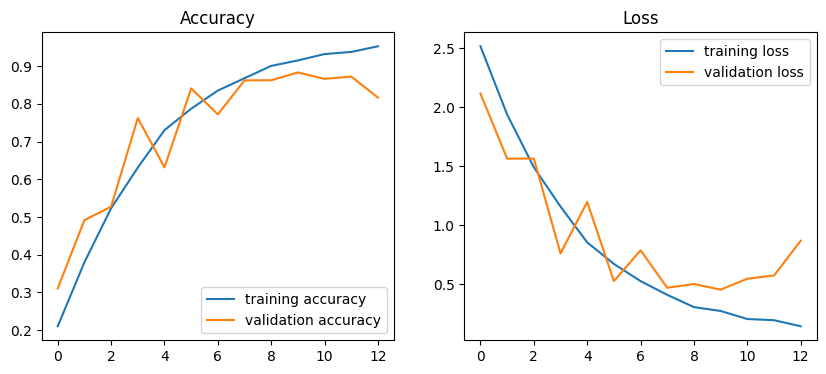

In [63]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Loss')

plt.show()

***
After using the data augmentated dataset and inputing the best hyperparameters into the model, we have achieved an increased accuracy of 88.33% compared to the initial model accuracy of 82.90%. The overfitting is also reduced when compared to the both inital and data augmented models.
***

In [64]:
# Save model weights
model.save_weights('./model_131.h5')

## Summary of CNN Model for pixel size of 131x131

***
- Initial model:
    - The base model on the original dataset has a good initial performance of model accuracy about 82.90%.
    - From the graph, there is some overfitting involved as the training accuracy line is above the validation accuracy line.
    - Data augmenetation could be done to help with overfitting and hyperparameter tuning could be done to help with increasing the model accuracy even more.

- Model after data augmentation:
    - The base model on the data augmeneted train dataset has a higher model accuracy of around 85.03%, which increased from 82.90% in the inital model without data augmentation.
    - From the graph, there is underfitting involved at the start of training but it improved towards the end where it became overfitted. 
    - Early stop tried to help to stop the epochs in order to prevent overfitting on the training dataset.

- Final model after data augmenetaion and hyper parameter tuning:
    - We have used RandomSearchCV to search for the "best" hyperparameters to be used with the data augmented train dataset.
    - The hyperparameter tuned model with data augmented train dataset has an accuracy of 88.33%.
    - The CNN model accuracy (88.33%) had a increase much compared to the initial model (82.90%). 
    - From the graph, we can see that the overfitting and underfitting has been reduced significantly from the initial model. 
    - The initial model has a difference of around 2.0 betweeen training and validation accuracy while there is about a differnce of 1.0 between training and validation loss. The final model has a difference of around 0.2 between training and validation accuracy while a difference of around 0.3 between training and validation loss.

Overall, data augmentation and hyperparameter tuning has been effective in allowing model to better train on the 131x131 pixel sized images, through an overall increase of CNN model accuracy, a lower CNN model error and the significant reduction of overfitting or underfitting.
***

## Conclusion

***
The classification accuracy of a convolutional neural network (CNN) can be influenced by various factors, including the size of the input images. Let's compare and discuss the potential impact of input size on classification accuracy for the given sizes: 37x37 pixels and 131x131 pixels.

37x37 Pixels:

- With smaller input sizes like 37x37 pixels, the CNN might struggle to capture intricate details and features in the images.
- Due to the limited information available in each image, the network may find it challenging to distinguish between similar classes or categories accurately.
- Training a CNN on such small images may lead to overfitting, where the network memorizes the training data rather than learning meaningful features, especially if the dataset is complex.
- Consequently, the classification accuracy might be lower compared to larger input sizes.


131x131 Pixels:

- Larger input sizes like 131x131 pixels provide more spatial information to the CNN.
- The network has a better chance of capturing fine details and features present in the images, which can improve its ability to discriminate between classes accurately.
- With more information available in each image, the network may generalize better to unseen data, leading to a higher classification accuracy.
- Training a CNN on larger images typically requires more computational resources and longer training times. However, the potential accuracy gains may justify this investment.


The classification accuracy of a CNN is likely to be higher for larger input sizes such as 131x131 pixels compared to smaller sizes like 37x37 pixels. However, the actual performance can also depend on factors such as the complexity of the dataset, the architecture of the CNN, and the quality of the training procedure. Going by that logic, the hypothesis that the model for 131x131 pixel should have better accuracy should be correct.

In this case, the accuracy for 37x37 pixel model after hypertuning and data augmentation is 85.53% while the accuracy for 131x131 pixel model after hypertuning and data augmentation is 88.33% proving that our hypothesis is true.
***